# Gender Pay Gap: Predicting income based on demographic data

## Abstract
What are the biggest indicators of a person's income? Their education level? Race? Gender? Age? What are demographic indicators that improve a woman's pay versus a man's?

For this project... 

## Introduction
As a teacher of underserved populations, I routinely tell my students that education is their greatest source of upward mobility.  I know that their race and, for the females, their gender currently work against them.  My biggest question is which of these factors are most important in increasing a person's income, and just how wide is the income gap for women, minorities, and those with lower levels of education?  A person cannot change most of these indicators, as those are the cards they are dealt in life, but of the ones they can change, how much of an impact does this have on income?

The data I will be using is extacted from the [1994 census bureau database](http://www.census.gov/ftp/pub/DES/www/welcome.html).  This dataset contains census data from approximately 32,000 working people over the age of 16, who made over 100 dollars that year, and who are representative of the larger population.  For each of these people, the dataset tracks a person's age, native country, marital status, education, employment, capital gains and losses as well as the target variable, whether or not the person's income was over $50,000 for that year.

### Research Questions
I will be attempting to answer the following questions:
- What demographic data is the best determinant for a person's income to be over \$50,000?
- Do those features differ between men and women?
- Do these features differe between white and non-white people?

### Models
To answer these questions, I will be using random forests, support vector machine classifier models, and logistic regression models.

## Imports

In [1]:
# Necessary imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='white', color_codes=True)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Cross calidation and statistics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

## Uploading, Cleaning, and Describing Data

In [2]:
# Column names from source documentation, and data separated by column and space
inc_raw = pd.read_csv('adult.data.csv', header=None, sep=', ',
                      names=['age','workclass','fnlwgt','education','education_num','marital_status',
                             'occupation','relationship','race','sex','capital_gain',
                            'capital_loss','hours_per_week','native_country','income'])
inc_raw.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
inc_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Based on this information, none of the columns have null values, and while 6 of the column entries are integer values, 9 of the column entries are categorical in nature.  Now, I will inspect the number of unique entries for each column to get a better sense of the data.

In [4]:
inc_raw.nunique()

age                  73
workclass             9
fnlwgt            21648
education            16
education_num        16
marital_status        7
occupation           15
relationship          6
race                  5
sex                   2
capital_gain        119
capital_loss         92
hours_per_week       94
native_country       42
income                2
dtype: int64

Some initial observations I had while inspecting the number of unique entries:
- The final weight column has the most unique values.  This column represents the number of people that an entry could represent.  This makes sense as to why this number is so large, because there is a large spread in the number of people who are similar to an entry.  In my analysis, I am not trying to model proportions of the population or total values for the population, I will drop this column from the data set.
- The education and education number columns both have 16 unique values.  This is because the level of education is represented numerically by the education number column.  I will inspect this further, but will only use one column in my analysis.
- There are 7 different marital status types, but 6 relationshp status types.  This is worth looking further into. 
- Capital gains and capital losses have a limited number of unique entries.  I would have expected more.  This tells me that there aren't many people who reported capital gains or losses this year. 
- A person's native country has 42 possible entries.  If I want to analyze this data based on immigrant status or race, I will likely need to make this category more broad. 

First, let's remove the final weight column from the data set.

In [5]:
inc = inc_raw.drop('fnlwgt', axis=1)

Now, let's inspect the different values in each of the columns to get a better sense of what each column is describing and clean the data where necessary.

In [6]:
inc.workclass.value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

This data set is very skewed in favor of employees of the private sector.  This makes sense because most of the work force is a part of the private sector.  There are also a good number of people employed by various governmnent entities, self-employed, and a small number either without pay or never worked.  I will combine those into three groups:
- Government
- Self-employed
- Not working  

There is also about 5% of the data that has unknown working class. I will drop these entries because it is impossible to impute the data or take the mean of the type of work, and these make up such a small portion of the data, so should not impact the overall analysis.

In [7]:
# Creating new data frame with updated working class categories
inc = inc[inc['workclass'] != '?']
inc.workclass = inc.workclass.map({'Private':'Private',
                                   'Self-emp-not-inc':'Self_employed','Self-emp-inc':'Self_employed',
                                    'Local-gov':'Government', 'State-gov':'Government', 'Federal-gov':'Government',
                                    'Without-pay':'Not_working', 'Never-worked':'Not_working'})
inc.workclass.value_counts()

Private          22696
Government        4351
Self_employed     3657
Not_working         21
Name: workclass, dtype: int64

Great! Next, let's inspect the education number to make sure that maps to the categorical education column.

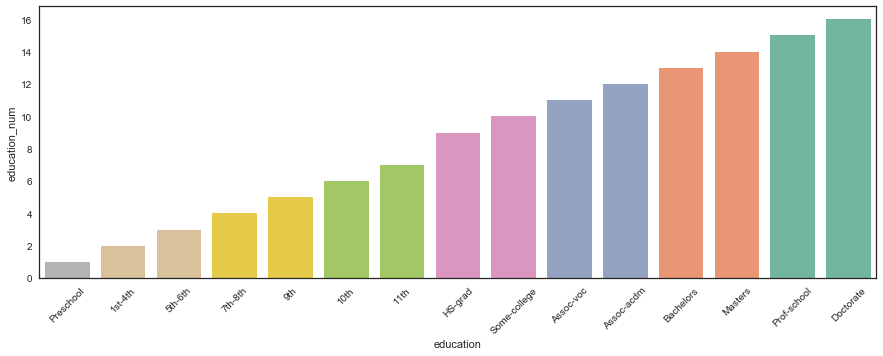

In [8]:
# First, establish estimated order of education, then plot
edu_order = ['Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th','HS-grad','Some-college',
            'Assoc-voc','Assoc-acdm','Bachelors','Masters','Prof-school','Doctorate']
plt.figure(figsize=(15,5))
sns.barplot(x='education', y='education_num', data=inc, palette='Set2_r', order=edu_order)
plt.xticks(rotation=45)
plt.show()

Yes, because there are no error bars on our plot, this indicates that education number indeed is directly correlated with the level of education.  Education number is an ordinal scale representing level of education because it doesn't indicate number of years of schooling, but rather the order of level achieved.  For our analyses, we will need either continuous or categorical dummies, so we will drop the education number column and later create dummies assuming we want this as a feature in our models.

In [9]:
inc = inc.drop('education_num', axis=1)

Next, let's check out marital status and the different options in this column.

In [10]:
inc.marital_status.value_counts()

Married-civ-spouse       14340
Never-married             9917
Divorced                  4259
Separated                  959
Widowed                    840
Married-spouse-absent      389
Married-AF-spouse           21
Name: marital_status, dtype: int64

Again, it looks like the majority of people are either married to civilians or never married, with a strong portion of people who were married but are now divorced. There are then people in categories with fewer people. These can be combined into three overall categories: 
- Never married
- Married (including married to a civilian spouse, and married to a spouse in the Armed Forces)
- No Longer Married (including divorced, separated, married to an absent spouse, and widowed)

In [11]:
inc.marital_status = inc.marital_status.map({'Married-civ-spouse':'Married', 'Married-AF-spouse':'Married',
                                             'Divorced':'No_longer_married', 'Separated':'No_longer_married',
                                             'Married-spouse-absent':'No_longer_married', 'Widowed':'No_longer_married',
                                            'Never-married':'Never-married'})
inc.marital_status.value_counts()

Married              14361
Never-married         9917
No_longer_married     6447
Name: marital_status, dtype: int64

Next, let's inspect the occupation options in this data set.

In [12]:
inc.occupation.value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
?                       7
Name: occupation, dtype: int64

It looks like there are still 7 people with unknown occupations.  I will drop these from the data set.  Otherwise, these categories are fairly distinct and, for the most part, individuals are evenly spread across all categories.  I will leave the rest as is for now, but I will keep in mind that there are a high number of different categories in this column that might be able to be condensed if needed.

In [13]:
inc = inc[inc.occupation != '?']

Next, we have the relationship column.  From the head of the Data Frame, it is unclear what this column represents, but I will inspect the value counts in this column.

In [14]:
inc.relationship.value_counts()

Husband           12704
Not-in-family      7865
Own-child          4525
Unmarried          3271
Wife               1435
Other-relative      918
Name: relationship, dtype: int64

I'm unsure what these values mean for any given person.  For this reason, I will drop this column from the data set.

In [15]:
inc = inc.drop('relationship', axis=1)

Next, I'll inspect the race column for its values.

In [16]:
print(inc.race.value_counts())

White                 26301
Black                  2909
Asian-Pac-Islander      974
Amer-Indian-Eskimo      286
Other                   248
Name: race, dtype: int64


As expected, there is a higher number of people who are white than other minority races.  To reduce this class imbalance, I will simplify this column into white and non-white populations.

In [17]:
inc.race = inc.race.map({'White':'White', 'Black':'Non-White','Asian-Pac-Islander':'Non-White',
                        'Amer-Indian-Eskimo':'Non-White','Other':'Non-White'})
inc.race.value_counts()

White        26301
Non-White     4417
Name: race, dtype: int64

The sex column has two unique values, male and female.  We will leave this and continue on to capital gain and capital loss.

In [18]:
print('Summary of Capital Gains:')
print(inc.capital_gain.describe())
print('\nSummary of Capital Losses:')
print(inc.capital_loss.describe())

Summary of Capital Gains:
count    30718.000000
mean      1106.037079
std       7497.863364
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital_gain, dtype: float64

Summary of Capital Losses:
count    30718.000000
mean        88.910216
std        405.657203
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capital_loss, dtype: float64


Wow! Most people reported no capital gains or losses. The maximum capital gain is \$99,999, or else this is a mistake. The largest capital loss is only \$4,356. Let's inspect the maximum value of capital gains and how capital gains and capital losses are related to one another.

In [19]:
inc[inc.capital_gain >= 99999]

,age,workclass,education,marital_status,occupation,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
1246,54,Self_employed,Prof-school,Married,Prof-specialty,White,Male,99999,0,60,United-States,>50K
1368,52,Private,HS-grad,Married,Exec-managerial,Non-White,Male,99999,0,40,Japan,>50K
1482,53,Self_employed,HS-grad,Married,Sales,White,Male,99999,0,40,United-States,>50K
1528,52,Private,Bachelors,Married,Exec-managerial,White,Male,99999,0,50,United-States,>50K
1616,46,Private,Prof-school,Married,Prof-specialty,White,Male,99999,0,60,United-States,>50K
1682,43,Private,Bachelors,Married,Exec-managerial,White,Male,99999,0,60,United-States,>50K
1765,49,Private,Bachelors,Married,Prof-specialty,White,Female,99999,0,20,United-States,>50K
1771,50,Private,Some-college,Married,Exec-managerial,White,Male,99999,0,50,United-States,>50K
1826,22,Self_employed,HS-grad,Never-married,Prof-specialty,White,Female,99999,0,40,Dominican-Republic,>50K
2103,43,Self_employed,Some-college,Married,Sales,White,Male,99999,0,55,United-States,>50K


There are 155 entries where the capital gains are \$99,999.  These all coincide with the income value of over \$50,000, making these values plausible.  

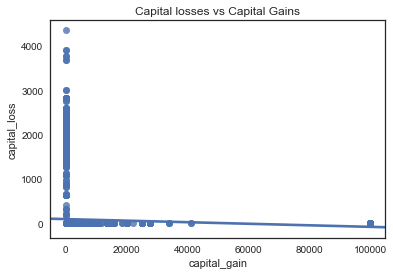

In [20]:
sns.regplot(x='capital_gain', y='capital_loss', data=inc)
plt.title('Capital losses vs Capital Gains')
plt.show()

## Exploratory Data Analysis

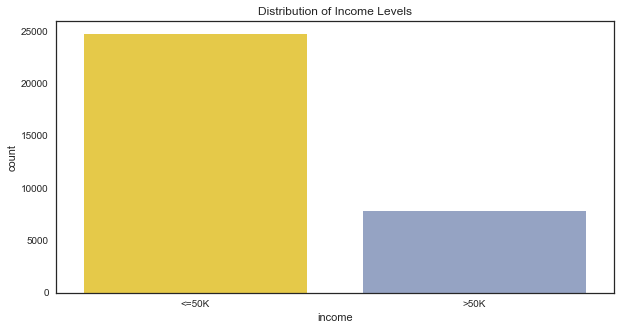

Percent of Low Income: 75.92%


In [21]:
plt.figure(figsize=(10,5))
sns.countplot(x='income', data=inc_raw, palette='Set2_r')
plt.title('Distribution of Income Levels')
plt.show()

print('Percent of Low Income: {:.2f}%'.format(len(inc_raw[inc_raw.income == '<=50K'])/len(inc_raw)*100))

76% of people have an income below \$50,000. There are more people that earn under \$50,000 per year, than people who don't. This means that I have a class imbalance and will need to consider under- or over-sampling in my modeling.

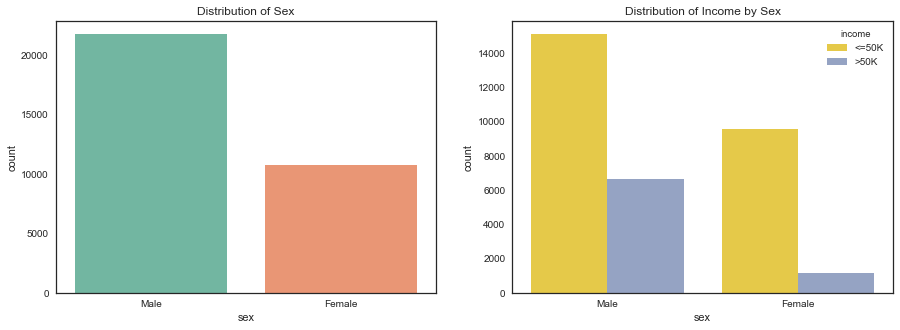

Percent of Male: 66.92%
Percent of Low Income Male: 69.43%


In [22]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(x='sex', data=inc_raw, palette='Set2')
plt.title('Distribution of Sex')

plt.subplot(122)
sns.countplot(x='sex', data=inc_raw, hue='income', palette='Set2_r')
plt.title('Distribution of Income by Sex')
plt.show()

inc_male = inc_raw[inc_raw.sex == 'Male']
print('Percent of Male: {:.2f}%'.format(len(inc_male)/len(inc_raw)*100))
print('Percent of Low Income Male: {:.2f}%'.format(len(inc_male[inc_male['income'] == '<=50K'])/len(inc_male)*100))

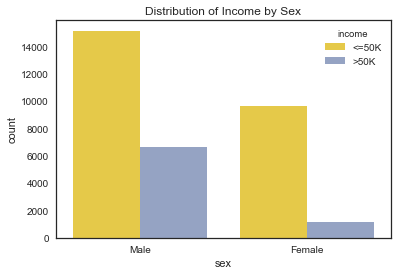

In [23]:
sns.countplot(x='sex', data=inc_raw, hue='income', palette='Set2_r')
plt.title('Distribution of Income by Sex')
plt.show()

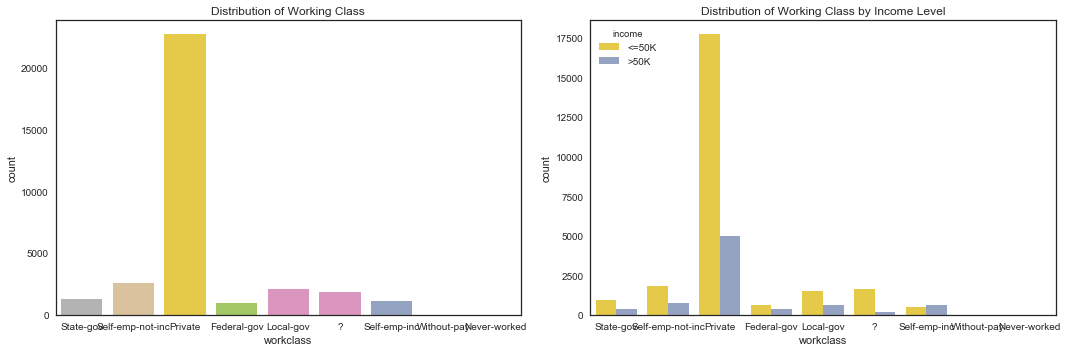

In [24]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(x='workclass', data=inc_raw, palette='Set2_r')
plt.title('Distribution of Working Class')

plt.subplot(122)
sns.countplot(x='workclass', hue='income', data=inc_raw, palette='Set2_r')
plt.title('Distribution of Working Class by Income Level')

plt.tight_layout()
plt.show()

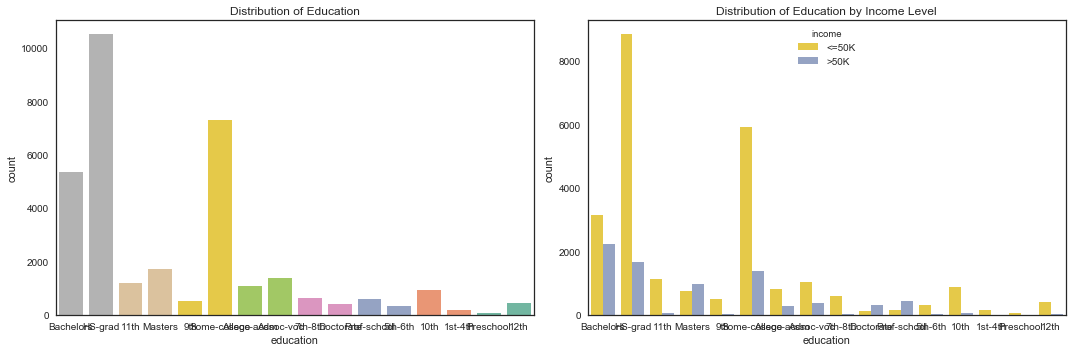

In [25]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(x='education', data=inc_raw, palette='Set2_r')
plt.title('Distribution of Education')

plt.subplot(122)
sns.countplot(x='education', hue='income', data=inc_raw, palette='Set2_r')
plt.title('Distribution of Education by Income Level')

plt.tight_layout()
plt.show()